# Embedding Trainer
---
Main script to train our various embedding models. What we'll do is import our 'Embedding Model' objects that we'll define in other files - and this code will be the training loop and will save the results to various folders.

## Create our Dataloader and Tokenizer
---
We already defined these and trained the tokenizer in the other files. So, let's go ahead and instantiate these as a first step

### Import Dependencies

In [2]:
# First - need to import sys and os and nav to our project_root
import sys
import os
import datetime

project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

# Now import our dependencies
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from dataloader.dataloader import MyDataLoader
from tokenizer.tokenizer import MyTokenizer

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Import our dataloader and tokenizer

In [5]:
# Import our dataloader
dl = MyDataLoader(
    batch_size=1, 
    shuffle=True)    

train_dataloader = dl.get_train_dataloader()
test_dataloader = dl.get_test_dataloader()

# Import tokenizer
tokenizer = MyTokenizer()
tk_vocab_size = tokenizer.get_vocab_size()

In [6]:
print(tk_vocab_size)

16384


In [4]:
# Get sample data and print
for batch in train_dataloader:
    sample_traindata = batch[0][0]
    break
for batch in test_dataloader:
    sample_testdata = batch[0][0]
    break

# Print data
chars_to_print = 100
print(f"Train Data Sample:\nNumber of chars: {len(sample_traindata)}\n{'='*60}")
print(sample_traindata[:chars_to_print])
print(tokenizer.encode_as_pieces(sample_traindata[:chars_to_print]))
print(f"\nTest Data Sample:\nNumber of chars: {len(sample_testdata)}\n{'='*60}")
print(sample_testdata[:chars_to_print])
print(tokenizer.encode_as_pieces(sample_testdata[:chars_to_print]))

Train Data Sample:
Number of chars: 1594
*poleon, that the good God is always on the side of the
heaviest artillery.

The religious myth meet
['▁*', 'p', 'oleon', ',', '▁that', '▁the', '▁good', '▁God', '▁is', '▁always', '▁on', '▁the', '▁side', '▁of', '▁the', '▁heav', 'iest', '▁artillery', '.', '▁The', '▁religious', '▁my', 'th', '▁meet']

Test Data Sample:
Number of chars: 2261
"Certainly nothing but the spirit in us is worth having," said Winterslow.

"Spirits!" said Jack, dr
['▁"', 'C', 'ertain', 'ly', '▁nothing', '▁but', '▁the', '▁spirit', '▁in', '▁us', '▁is', '▁worth', '▁having', ',"', '▁said', '▁W', 'in', 'ters', 'low', '.', '▁"', 'S', 'p', 'irits', '!"', '▁said', '▁Jack', ',', '▁dr']


## Define our Helper Functions

In [5]:
def _yield_CBOW_batch(text, n_window, batch_size=8, util_rate=0.5, spec_iter=None, vocab_size=tk_vocab_size, device=device, tokenizer=tokenizer):
    """
        Generator function that takes in text and returns a number of batches for each dataset based on the utilization rate specified. To be used in a CBOW model.

        Inputs:
            text:       (string) The text provided by the dataloader
            n_window:   (int) Size of our context window for the CBOW model. I.e., if n_window=4, then we will use the left 4 words and right 4 words to predict our target word
            batch_size: (int) Number of samples to return in each batch
            util_rate:  (float) Value from (0, 1] that specifies the % of possible batches that are generated before moving to next sample
            spec_iter:  (int) If set to none, we use util rate to determine num batches from this data. If set to an int, we use that number.
            vocab_size: (int) size of our tokenizer vocabulary
            device:     Pytorch device (e.g., cuda / cpu)
            tokenizer:  Our defined tokenizer (above). encode_as_ids(text) returns a 1-D python list of tokens

        Yields (generator function) batches of data in the form of GPU-mounted pytorch tensors until util_rate is tripped.
    """
    # Tokenize our data and determine number of batches we'll use
    tokens = torch.tensor(tokenizer.encode_as_ids(text), dtype=torch.int, device=device)
    len_tokens = len(tokens)
    num_possible_pairs = len_tokens - (2 * n_window)
    num_batches = int((num_possible_pairs * util_rate) // batch_size) if spec_iter==None else min(spec_iter, int(num_possible_pairs // batch_size))

    # Get random permutation of the possible 'center indices' --> these become our targets and surrounding 'n_window' size is our context
    center_indices = torch.arange(n_window, len_tokens - n_window, device=device).int()
    center_indices = center_indices[torch.randperm(center_indices.size(0))][:num_batches*batch_size]

    # Generate # of batches for this dataset
    for i in range(num_batches):
        batch_center_indices = center_indices[i*batch_size:(i+1)*batch_size]
        context_indices_list = []
        target_indices_list = []
        
        for center_idx in batch_center_indices:
            # Create a context window around the center word
            context_window = tokens[(center_idx - n_window):(center_idx + n_window + 1)]
            context_indices = torch.cat((context_window[:n_window], context_window[n_window+1:]))
            target_index = tokens[center_idx]
            
            context_indices_list.append(context_indices)
            target_indices_list.append(target_index)
        
        # Stack lists to create batch tensors
        context_tensor = torch.stack(context_indices_list).to(device)
        target_tensor = torch.stack(target_indices_list).to(device)
        
        yield context_tensor, target_tensor

for batch, (context, target) in enumerate(_yield_CBOW_batch(sample_traindata, n_window=4)):
    print(f"Batch {batch+1}")
    print(f"{'-'*60}")
    print(context)
    print(target)
    break

Batch 1
------------------------------------------------------------
tensor([[  336,  2904, 10003,    74,   453,   243,    98,     6],
        [   58,  2985,    16,  2529,    32,   195,  1897, 16232],
        [   16,  2529,   502,    32,  1897, 16232,  1485, 16210],
        [ 8619,  1717,    43,  5741, 16210,  5499,  4046,   197],
        [16194,   128,    74,  1917,    33,   663,   138,    21],
        [ 2177,   598,  3434,    33,  2904, 12757,  2441,   424],
        [16210,    74,  1717,    43, 16210,  1824, 16210,   200],
        [   63,   272,    93,    44,   111,     6,   965, 15152]],
       device='cuda:0', dtype=torch.int32)
tensor([    6,   502,   195, 12757,   177,     6,  5741, 14393],
       device='cuda:0', dtype=torch.int32)


In [6]:
# Next - let's keep track of our loss data
def _estimate_loss(model, n_window, batching_fn, train_dl, test_dl, n_samples=10, iters_per_sample=10, device=device):
    """
        Function to estimate our loss (train and test) that we can call

        Inputs:
            model:             Pytorch sequential model
            n_window:          (int) Specify size of window to test over (for our CBOW / Skipgram models)
            batching_fn:       Function that returns our data as (context, targets)
            train_dl:          Pytorch dataloader for train data
            test_dl:           Pytorch dataloader for test data
            n_samples:         (int) Specify number of iterations to compute loss over
            iters_per_sample:  (int) Specify number of iterations per sample to compute loss over
            device:            Pytorch device (cuda / cpu)

        Returns the mean train loss and the test loss over n_iters samples
    """
    train_loss = torch.zeros(n_samples*iters_per_sample, device=device)
    test_loss = torch.zeros(n_samples*iters_per_sample, device=device)

    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(train_dl):
            for (context, targets) in batching_fn(sample[0][0], n_window, spec_iter=iters_per_sample):
                loss = model(context, targets)
                train_loss[i-1] += loss
            if i == n_samples:
                break
        for i, sample in enumerate(test_dl):
            for (context, targets) in batching_fn(sample[0][0], n_window, spec_iter=iters_per_sample):
                loss = model(context, targets)
                test_loss[i-1] += loss
            if i == n_samples:
                break

    model.train()
    return train_loss.mean(), test_loss.mean()

## Import and Train our Model
---

### Standard Negative Sampling

In [12]:
# Continuous Bag of Words model for training embeddings as specified in Word2Vec (https://arxiv.org/pdf/1301.3781.pdf)
class CBOW_NegativeSampling(nn.Module):
    def __init__(self, embed_dim, tokenizer, effic_strat=None, vocab_size=tk_vocab_size, device=device):
        """
        Inputs:
            embed_dim:   (int) number of dimensions for our embeddings
            effic_strat: (str) either 'neg-sample' or 'hier-softmax' - used to define which strategy for efficient computation to use
            vocab_size:  (int) the size of the vocabulary
            device:      Pytorch device (cuda / cpu)
        """
        super().__init__()
        self.device = device
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.tokenizer = tokenizer
        self.token_frequencies = tokenizer.get_frequency_tensor().to(device)
        self.embeddings = nn.Embedding(vocab_size, embed_dim).to(device)
        
        self.initialize_embeddings()

    def initialize_embeddings(self):
        """ Initializes the embedding weights to a normal distribution with mean 0 and a specified variance """
        nn.init.normal_(self.embeddings.weight, mean=0.0, std=1)

    def forward(self, context_indices, positive_indices, num_negative_samples=5):
        """
            Performs a forward pass with negative sampling.
            
            Parameters:
            - context_indices: Indices of the context words [B, Context_size].
            - positive_indices: Indices of the target (positive) words [B, 1].
            - num_negative_samples: Number of negative samples per positive sample.
        """
        # Get the embeddings for our context vectors and average -- will use this to estimate for our positive and negative samples
        batch_size = context_indices.size(0)
        context_embeds = self.embeddings(context_indices).mean(dim=1, keepdims=True)         # [B, context_size, embed_dim] --> [B x 1 x embed_dim]
    
        # Compute loss on positive samples (what we're looking for)
        positive_embeds = self.embeddings(positive_indices).unsqueeze(-1)                    # [B, embed_dim, 1]
        positive_logits = torch.bmm(context_embeds, positive_embeds).squeeze()               # [B x 1 x embed_dim] @ [B, embed_dim, 1] -> [B, 1, 1] -> [B]
        positive_labels = torch.ones_like(positive_logits)
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, positive_labels) # [B]
    
        # Compute loss on negative samples (teach model to move negative samples away from each other
        negative_indices = torch.multinomial(self.token_frequencies, num_samples=batch_size*num_negative_samples, replacement=True).reshape(batch_size, num_negative_samples)
        negative_embeds = self.embeddings(negative_indices).transpose(1,2)                   # [B, embed_dim, num_negative_samples]
        negative_logits = torch.bmm(context_embeds, negative_embeds).squeeze()               # [B, num_negative_samples]
        negative_labels = torch.zeros_like(negative_logits)
        negative_loss = F.binary_cross_entropy_with_logits(negative_logits, negative_labels) # [B, num_negative_samples]

        return positive_loss + negative_loss.mean()   # [B]

    def find_closest_embeddings(self, input_embedding, n=5):
        """
            Find the n embeddings in the model that have the largest cosine similarity
            to the given input_embedding.
    
            Inputs:
                input_embedding (Tensor): The input embedding vector.
                n (int): The number of closest embeddings to return.
    
            Returns a tensor of indices of the n closest embeddings.
        """
        input_embedding_norm = input_embedding / input_embedding.norm()                    # [1 x emb_dim]
        all_embeddings = self.embeddings.weight
        all_embeddings_norm = all_embeddings / all_embeddings.norm(dim=1, keepdim=True)    # [vocab_size x emb_dim]
        similarities = F.cosine_similarity(input_embedding_norm, all_embeddings_norm, dim=1)
        values, indices = torch.topk(similarities, n)
        return indices

    def get_embedding(self, index):
        """ Retrieve the vector embedding corresponding to a given index Returns a tensor of the embedding vector """
        return self.embeddings.weight[index]

    def save_weights(self, filename):
        """ Save the model weights to a file """
        torch.save(self.state_dict(), filename)

    def load_weights(self, filename):
        """ Load the model weights from a file. Ex. 'trained_models/mymodel.pth' """
        self.load_state_dict(torch.load(filename, map_location=self.device))
        print(f"Model weights loaded from {filename}")

    def export_embeddings(self, filename):
        """
        Exports only the embeddings to a file.
        
        Parameters:
        - filename: (str) the filename to save the embeddings to.
        """
        torch.save(self.embeddings.weight.data, filename)
        print(f"Embeddings exported to {filename}")

In [9]:
# Continuous Bag of Words model for training embeddings as specified in Word2Vec (https://arxiv.org/pdf/1301.3781.pdf)
# Hierarchal Softmax modeled off impelmentation from this paper (https://www.cs.toronto.edu/~amnih/papers/hlbl_final.pdf)
from models.hierarchalsoftmax_node import BinaryVocabularyNode


### OLD ONE WITH SVM TRAINING

class CBOW_NegativeSampling_HS1(nn.Module):
    def __init__(self, embed_dim, tokenizer, vocab_fp = None, vocab_size = tk_vocab_size, device = device):
        """
        Inputs:
            embed_dim:   (int) number of dimensions for our embeddings
            tokenizer:   Tokenizer object we will use for tokenization
            vocab_fp:    Filepath to our pre-trained embeddings that we'll use to create our hierarchal softmax implementation
            vocab_size:  (int) the size of the vocabulary
            device:      Pytorch device (cuda / cpu)
        """
        super().__init__()
        # Instantiate basic class vars
        self.device = device
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.tokenizer = tokenizer
        self.token_frequencies = tokenizer.get_frequency_tensor().to(device)
        
        # Instantiate our embeddings. Use loaded embeddings if pre-trained else randomize
        self.embeddings = nn.Embedding(vocab_size, embed_dim).to(device)
        self.initialize_embeddings() if vocab_fp == None else self.load_weights(vocab_fp)
        
        # Instantiate our hierarchal softmax tree
        self.tree_root = None
        self.node_params = torch.zeros((1, embed_dim+1)).to(device)
        self.build_tree_structure()

    def initialize_embeddings(self):
        """ Initializes the embedding weights to a normal distribution with mean 0 and std = 1"""
        nn.init.normal_(self.embeddings.weight, mean=0.0, std=1.0)

    def build_tree_structure(self):
        """
            Function that takes our embeddings and produces an embedding tree using GMM to cluster the embeddings.
            If we pass 'vocab_fp' in, this will use our pre-trained embeddings to define our tree. Otherwise, it will be randomly generated
        """
        def recursive_gmm_clustering(vectors, indices):
            if vectors.shape[0] == 1:
                return BinaryVocabularyNode(isleaf=True, vectoridx=indices.item())
            
            gmm = GaussianMixture(n_components=2, random_state=0, max_iter=50).fit(vectors.cpu().numpy())
            labels = gmm.predict(vectors.cpu().numpy())
        
            # Train SVM on the two resulting clusters
            svm = SVC(kernel='linear', C=1.0, random_state=0, max_iter=100)
            svm.fit(vectors.cpu().numpy(), labels)
            weights = torch.tensor(svm.coef_[0], dtype=torch.float32, device=self.device)
            bias = torch.tensor(svm.intercept_[0], dtype=torch.float32, device=self.device)
            
            # Update params
            node_idx = self.node_params.size(0)
            print(f"Node: {node_idx}")
            new_params = torch.cat([weights, bias.unsqueeze(0)], dim=0).unsqueeze(0)
            self.node_params = torch.cat([self.node_params, new_params], dim=0)
        
            # Recursive call
            leftchild = recursive_gmm_clustering(vectors[labels == 0], indices[labels == 0])
            rightchild = recursive_gmm_clustering(vectors[labels == 1], indices[labels == 1])
            return BinaryVocabularyNode(isleaf=False, vectoridx=node_idx, leftchild=leftchild, rightchild=rightchild)
        
        initial_indices = torch.arange(self.vocab_size, device=self.device)
        self.tree_root = recursive_gmm_clustering(self.embeddings.weight.detach(), initial_indices)

                                                  
    def forward(self, context_indices, positive_indices, num_negative_samples=5):
        pass

    def find_closest_embeddings(self, input_embedding, n=5):
        """
            Find the n embeddings in the model that have the largest cosine similarity
            to the given input_embedding.
    
            Inputs:
                input_embedding (Tensor): The input embedding vector.
                n (int): The number of closest embeddings to return.
    
            Returns a tensor of indices of the n closest embeddings.
        """
        input_embedding_norm = input_embedding / input_embedding.norm()                    # [1 x emb_dim]
        all_embeddings = self.embeddings.weight
        all_embeddings_norm = all_embeddings / all_embeddings.norm(dim=1, keepdim=True)    # [vocab_size x emb_dim]
        similarities = F.cosine_similarity(input_embedding_norm, all_embeddings_norm, dim=1)
        values, indices = torch.topk(similarities, n)
        return indices

    def get_embedding(self, index):
        """ Retrieve the vector embedding corresponding to a given index Returns a tensor of the embedding vector """
        return self.embeddings.weight[index]

    def save_weights(self, filename):
        """ Save the model weights to a file """
        torch.save(self.state_dict(), filename)

    def load_weights(self, filename):
        """ Load the model weights from a file. Ex. 'trained_models/mymodel.pth' """
        self.load_state_dict(torch.load(filename, map_location=self.device))
        print(f"Model weights loaded from {filename}")

### Hierarchal Softmax

In [7]:
# Continuous Bag of Words model for training embeddings as specified in Word2Vec (https://arxiv.org/pdf/1301.3781.pdf)
# Hierarchal Softmax modeled off impelmentation from this paper (https://www.cs.toronto.edu/~amnih/papers/hlbl_final.pdf)
from models.hierarchalsoftmax_node import BinaryVocabularyNode
from models.gmm import GaussianMixtureModel

class CBOW_NegativeSampling_HS(nn.Module):
    def __init__(self, embed_dim, tokenizer, vocab_fp=None, vocab_size=10000, device='cuda'):
        super().__init__()
        self.device = device
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.tokenizer = tokenizer
        self.token_frequencies = tokenizer.get_frequency_tensor().to(device)
        
        self.embeddings = nn.Embedding(vocab_size, embed_dim).to(device)
        if vocab_fp is None:
            self.initialize_embeddings()
        else:
            self.load_weights(vocab_fp)
            self.embeddings.weight.data = F.normalize(self.embeddings.weight.data, p=2, dim=-1)
        
        # Instantiate our hierarchical softmax tree
        self.tree_root = None
        self.gmm_params = []  # List to store GMM parameters
        self.build_tree_structure()

    def initialize_embeddings(self):
        """ Initializes the embedding weights to a normal distribution with mean 0 and std = 1"""
        nn.init.normal_(self.embeddings.weight, mean=0.0, std=1.0)

    def build_tree_structure(self):
        """
        Function that takes our embeddings and produces an embedding tree using GMM to cluster the embeddings.
        If we pass 'vocab_fp' in, this will use our pre-trained embeddings to define our tree. Otherwise, it will be randomly generated
        """
        embs = self.embeddings.weight.detach()
        
        def recursive_gmm_clustering(indices):
            if indices.sum() == 1:
                return BinaryVocabularyNode(isleaf=True, vectoridx=torch.argmax(indices).item())
            
            gmm = GaussianMixtureModel(X=embs[indices, :], k_clusters=2, device=device)
            gmm.to(device)
            gmm.fit(X=embs[indices, :], max_steps=20)
            labels = gmm.forward(embs[indices, :])
            self.gmm_params.append(gmm.export_weights())
            print(len(self.gmm_params))

            # Recursive call
            leftchild = recursive_gmm_clustering(indices - labels)
            rightchild = recursive_gmm_clustering(labels)
            return BinaryVocabularyNode(isleaf=False, vectoridx=len(self.gmm_params)-1, leftchild=leftchild, rightchild=rightchild)
        
        self.tree_root = recursive_gmm_clustering(torch.arange(self.vocab_size, device=self.device))

    def forward(self, context_indices, positive_indices, num_negative_samples=5):
        # Implementation of the forward pass
        pass

    def find_closest_embeddings(self, input_embedding, n=5):
        """
            Find the n embeddings in the model that have the largest cosine similarity
            to the given input_embedding.
    
            Inputs:
                input_embedding (Tensor): The input embedding vector.
                n (int): The number of closest embeddings to return.
    
            Returns a tensor of indices of the n closest embeddings.
        """
        input_embedding_norm = input_embedding / input_embedding.norm()                    # [1 x emb_dim]
        all_embeddings = self.embeddings.weight
        all_embeddings_norm = all_embeddings / all_embeddings.norm(dim=1, keepdim=True)    # [vocab_size x emb_dim]
        similarities = F.cosine_similarity(input_embedding_norm, all_embeddings_norm, dim=1)
        values, indices = torch.topk(similarities, n)
        return indices

    def get_embedding(self, index):
        """ Retrieve the vector embedding corresponding to a given index Returns a tensor of the embedding vector """
        return self.embeddings.weight[index]

    def save_weights(self, filename):
        """ Save the model weights to a file """
        torch.save(self.state_dict(), filename)

    def load_weights(self, filename):
        """ Load the model weights from a file. Ex. 'trained_models/mymodel.pth' """
        self.load_state_dict(torch.load(filename, map_location=self.device))
        print(f"Model weights loaded from {filename}")

Convergence reached at step 15.


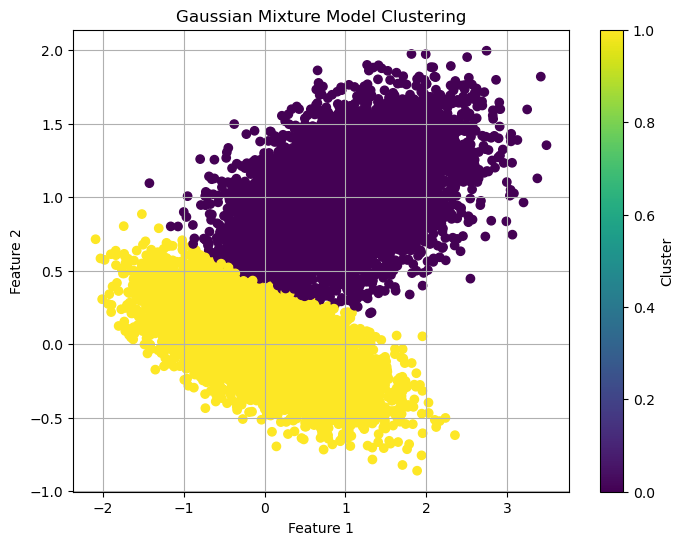

In [8]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix

# Assuming GaussianMixtureModel is imported
# from gmm import GaussianMixtureModel

# Generate synthetic data
def generate_data(n_samples, means, covariances, weights):
    n_clusters = len(weights)
    data = []
    for i in range(n_clusters):
        data.append(torch.distributions.MultivariateNormal(
            torch.tensor(means[i], dtype=torch.float32),  # Ensure means are float32
            torch.tensor(covariances[i], dtype=torch.float32)  # Ensure covariances are float32
        ).sample((int(weights[i] * n_samples),)))
    return torch.cat(data).to(device)

# Define parameters for synthetic data
n_samples = 16000
means = [[0, 0], [1, 1]]
covariances = [make_spd_matrix(2) * 0.2 for _ in range(2)]  # Making sure the covariance matrices are positive definite
weights = [0.5, 0.5]

# Generate the data
X = generate_data(n_samples, means, covariances, weights)

# Initialize the GMM
gmm = GaussianMixtureModel(X=X, k_clusters=2, device=device)
gmm.to(device)
gmm.fit(X)
labels = gmm.forward(X)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=labels.cpu(), cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


In [ ]:
hs_model = CBOW_NegativeSampling_HS(embed_dim=512, 
                         tokenizer=tokenizer, 
                         vocab_fp="trained_models\CBOW-5-NS-16k-2024-04-20_13-59.pth", 
                         vocab_size=tk_vocab_size, 
                         device=device)

Model weights loaded from trained_models\CBOW-5-NS-16k-2024-04-20_13-59.pth
1
2
3
4
5
6
7
8
9
10
11
12
13


In [24]:
tot_words = hs_model.vocab_size
num_right = 0

for i in range(tot_words):
    emb = hs_model.get_embedding(i)
    emb = emb.unsqueeze(0)  # Reshape embedding to [1, embedding_size]

    node = hs_model.tree_root
    while not node.isleaf:
        # Retrieve centroids directly as tensors and ensure they are on the correct device
        centroid1, centroid2 = hs_model.gmm_params[node.vectoridx]
        centroid1 = torch.tensor(centroid1, dtype=torch.float, device=device).unsqueeze(0)
        centroid2 = torch.tensor(centroid2, dtype=torch.float, device=device).unsqueeze(0)
        
        # Calculate Euclidean distances to both centroids
        dist_to_c1 = torch.norm(emb - centroid1, dim=1)
        dist_to_c2 = torch.norm(emb - centroid2, dim=1)

        # Decide which path to take based on which centroid is closer
        node = node.leftchild if dist_to_c1 < dist_to_c2 else node.rightchild

    # Check if the leaf node index matches the current word index
    if node.vectoridx == i:
        num_right += 1

print(f"Number of correct leaf nodes reached: {num_right}/{tot_words}")

torch.Size([1, 2, 512, 512])


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
token_codes = {key: None for key in range(hs_model.vocab_size)}

# Fill in token_codes using recursive parse of tree
root = hs_model.tree_root

def parse_tree(node, curpath):
    if node.isleaf:
        token_codes[node.vectoridx] = curpath
    else:
        parse_tree(node.leftchild, curpath+"L")
        parse_tree(node.rightchild, curpath+"R")

parse_tree(root, "")

In [ ]:
losses = torch.zeros((hs_model.vocab_size, 1), device=device)

for i in range(hs_model.vocab_size):
    emb = hs_model.get_embedding(i)  # Get embedding for word i
    emb = emb.unsqueeze(0)  # Make it [1, embedding_size] to compute distances

    node = hs_model.tree_root
    loss = 0.0  # Initialize loss for this word

    while not node.isleaf:
        # Get the centroids for the current node
        centroids = torch.tensor(hs_model.gmm_params[node.vectoridx][0], device=device)  # Load means from gmm_params
        centroid1, centroid2 = centroids[0].unsqueeze(0), centroids[1].unsqueeze(0)  # Ensure correct shape

        # Calculate distances to the two centroids
        dist_to_c1 = torch.norm(emb - centroid1, dim=1)
        dist_to_c2 = torch.norm(emb - centroid2, dim=1)

        # Determine the expected path based on the smaller distance
        expected_direction = 'L' if dist_to_c1 < dist_to_c2 else 'R'
        actual_direction = 'L' if torch.argmin(torch.stack([dist_to_c1, dist_to_c2])) == 0 else 'R'

        # Calculate binary cross-entropy loss for this decision
        prob_correct = torch.sigmoid(-dist_to_c1 if expected_direction == 'L' else -dist_to_c2)
        loss += -torch.log(prob_correct.clamp(min=1e-10))  # Use clamp to avoid log(0)

        # Move to the appropriate child node based on actual closest centroid
        node = node.leftchild if actual_direction == 'L' else node.rightchild

    losses[i] = loss

In [ ]:
lengths = []

for i in range(hs_model.vocab_size):
    lengths.append(len(token_codes[i]))

lengths = torch.tensor(lengths, dtype=torch.float, device=device).reshape(-1, 1)

print(f"Stats on code lengths:\n{'-'*50}")
print(f"Mean:   {lengths.mean():.3f}")
print(f"Median: {lengths.median():.3f}")
print(f"Min:    {lengths.min():.3f}")
print(f"Max:    {lengths.max():.3f}")

print(f"\nStats on our vocabulary tree:\n{'-'*50}")
print(f"Mean:   {losses.mean():.3f}")
print(f"Median: {losses.median():.3f}")
print(f"Min:    {losses.min():.3f}")
print(f"Max:    {losses.max():.3f}")

loss_len = losses / lengths
print(f"\nLosses / Lengths:\n{'-'*50}")
print(f"Mean:   {loss_len.mean():.3f}")
print(f"Median: {loss_len.median():.3f}")
print(f"Min:    {loss_len.min():.3f}")
print(f"Max:    {loss_len.max():.3f}")

In [14]:
# Define a simple training loop
def train_model(embedding_model, train_dl, test_dl, tokenizer, device, embed_dim, learning_rate, epochs, max_iters, print_freq=2000, saveweights=True):
    """
    Main training loop for the model specified in 'embedding_model'.
    
    Parameters:
    - embedding_model: The key to the embedding model configuration.
    - train_dl: Training DataLoader.
    - test_dl: Testing DataLoader.
    - tokenizer: Tokenizer used for encoding text.
    - device: The device (cuda/cpu) on which to train the model.
    - epochs: Number of epochs to train for.
    - saveweights: Whether to save the model weights.
    - embed_dim: Dimensionality of the embeddings.
    - learning_rate: Learning rate for the optimizer.
    """
    modelclass = emb_model[embedding_model]["modelclass"]
    n_window = emb_model[embedding_model]["n_window"]
    batching_fn = emb_model[embedding_model]["batching_fn"]
    
    model = modelclass(embed_dim=embed_dim, 
                       tokenizer=tokenizer,
                       device=device)
    model.to(device)
    print(f"Using device: {device}")
    print(f"{(sum(p.numel() for p in model.parameters())/1e6):.3f}M parameters")
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = torch.zeros(int(max_iters//print_freq), 3, device=device)
    iter = 0

    def save_model_and_losses():
        datetime_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
        file_prefix = f"{embedding_model}-{tokenizer.get_vocab_size()//1000}k-{datetime_str}"
        weights_path = os.path.join('trained_models', file_prefix + '.pth')
        model.save_weights(weights_path)
        print(f"Model weights saved to {weights_path}")
        
        losses_df = pd.DataFrame(losses.cpu().numpy(), columns=['Iteration', 'Train Loss', 'Test Loss'])
        csv_path = os.path.join('loss_results', file_prefix + '.csv')
        losses_df.to_csv(csv_path, index=False)
        print(f"Loss data saved to {csv_path}")
    
    for _ in range(epochs):
        for sample in train_dl:
            for (context, targets) in batching_fn(sample[0][0], n_window):
                iter += 1
                loss = model(context, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if iter % print_freq == 0:
                    train_loss, test_loss = _estimate_loss(model, n_window, batching_fn, train_dl, test_dl, n_samples=5, iters_per_sample=10, device=device)
                    print(f"{iter}/{int(max_iters)}: Train loss = {train_loss:.3f}; Test loss = {test_loss:.3f}")
                    
                    print_idx = iter//print_freq - 1
                    losses[print_idx] = torch.tensor([iter, train_loss, test_loss], device=device)

                if iter % 1e6 == 0:
                    save_model_and_losses()
                
                if iter >= max_iters:
                    save_model_and_losses()
                    return

In [10]:
# Defining our different embedding models
emb_model = {
    "CBOW-5-NS": {"modelclass": CBOW_NegativeSampling, "batching_fn": _yield_CBOW_batch, "n_window": 5},
    "CBOW-5-HS": {"modelclass": CBOW_NegativeSampling_HS, "batching_fn": _yield_CBOW_batch, "n_window": 5},
    "Ngram-5-NS": {"modelclass": "TBD", "batching_fn": "TBD", "n_window": 5},
    "Ngram-5-HS": {"modelclass": "TBD", "batching_fn": "TBD", "n_window": 5},
 }

# Training specific hyperparams
embedding_model = "CBOW-5-HS"
learning_rate = 3e-4
embed_dim = 512
epochs = 50

# Training our model
loss = train_model(embedding_model=embedding_model, 
                   train_dl=train_dataloader, 
                   test_dl=test_dataloader, 
                   tokenizer=tokenizer, 
                   device=device, 
                   embed_dim=embed_dim, 
                   learning_rate=learning_rate, 
                   epochs=epochs,
                   max_iters=1e7,
                   print_freq=10000)

Using device: cuda
8.389M parameters
10000/10000000: Train loss = 8.200; Test loss = 7.300
20000/10000000: Train loss = 5.647; Test loss = 6.211
30000/10000000: Train loss = 4.948; Test loss = 5.197
40000/10000000: Train loss = 5.000; Test loss = 4.415
50000/10000000: Train loss = 4.338; Test loss = 4.539
60000/10000000: Train loss = 4.342; Test loss = 4.372
70000/10000000: Train loss = 3.926; Test loss = 3.914
80000/10000000: Train loss = 3.784; Test loss = 4.004
90000/10000000: Train loss = 3.379; Test loss = 3.850
100000/10000000: Train loss = 3.581; Test loss = 3.661
110000/10000000: Train loss = 3.565; Test loss = 3.647
120000/10000000: Train loss = 3.398; Test loss = 3.398
130000/10000000: Train loss = 3.451; Test loss = 3.431
140000/10000000: Train loss = 3.247; Test loss = 3.234
150000/10000000: Train loss = 2.948; Test loss = 3.157
160000/10000000: Train loss = 3.027; Test loss = 3.123
170000/10000000: Train loss = 3.057; Test loss = 3.120
180000/10000000: Train loss = 2.973; 

## Plotting Loss and Testing our Trained Models
---

In [9]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [10]:
# Define the filename (don't include .pth or .csv) for the weights we want to use
model_fn = "CBOW-5-NS-16k-2024-04-20_23-29"
# model_fn = "CBOW-5-NS-16k-2024-04-20_13-59"

In [15]:
def exponential_decay(x, a, b, c):
    """ Returns the exponential decay model y = a * exp(-b * x) + c. """
    return a * np.exp(-b * x) + c

def visualize_loss(filename: str, rolling_window: int | None = None, start_log_iter: float = 0):
    """
    Plots training and testing loss, fits an exponential decay model from a specified log(iteration).
    
    Parameters:
        filename (str): CSV file path with 'Iteration', 'Train Loss', 'Test Loss'.
        rolling_window (int, optional): Window size for rolling average.
        start_log_iter (float, optional): Starting log(iteration) value for fitting.

    Returns:
        tuple: Fitted parameters for the training and testing loss models.
    """
    df = pd.read_csv(os.path.join('loss_results', filename))
    df = df[df['Iteration'] > 0]
    df['Log Iteration'] = np.log(df['Iteration'])

    if rolling_window is not None:
        df['Train Loss'] = df['Train Loss'].rolling(window=rolling_window, min_periods=1).mean()
        df['Test Loss'] = df['Test Loss'].rolling(window=rolling_window, min_periods=1).mean()

    fit_df = df[df['Log Iteration'] >= start_log_iter]
    log_train_x_fit = fit_df['Log Iteration']
    train_y_fit = fit_df['Train Loss']
    log_test_x_fit = fit_df['Log Iteration']
    test_y_fit = fit_df['Test Loss']

    popt_train, _ = curve_fit(exponential_decay, log_train_x_fit, train_y_fit, p0=(max(train_y_fit), 0.01, min(train_y_fit)))
    popt_test, _ = curve_fit(exponential_decay, log_test_x_fit, test_y_fit, p0=(max(test_y_fit), 0.01, min(test_y_fit)))

    plt.figure(figsize=(10, 6))
    plt.plot(df['Log Iteration'], df['Train Loss'], 'b-', label='Train Loss', alpha=0.3)
    plt.plot(df['Log Iteration'], df['Test Loss'], 'r-', label='Test Loss', alpha=0.3)
    plt.plot(log_train_x_fit, exponential_decay(log_train_x_fit, *popt_train), 'b--', label='Train Loss Fit')
    plt.plot(log_test_x_fit, exponential_decay(log_test_x_fit, *popt_test), 'r--', label='Test Loss Fit')
    plt.axvline(x=start_log_iter, color='gray', linestyle='--', label='Start of Fit')
    plt.title('Training and Test Loss Over Time (Log-scaled x-axis)')
    plt.xlabel('Log of Iteration')
    plt.ylabel('Loss')
    plt.legend()
    # plt.ylim(1.3, 2)
    plt.show()

    return popt_train, popt_test

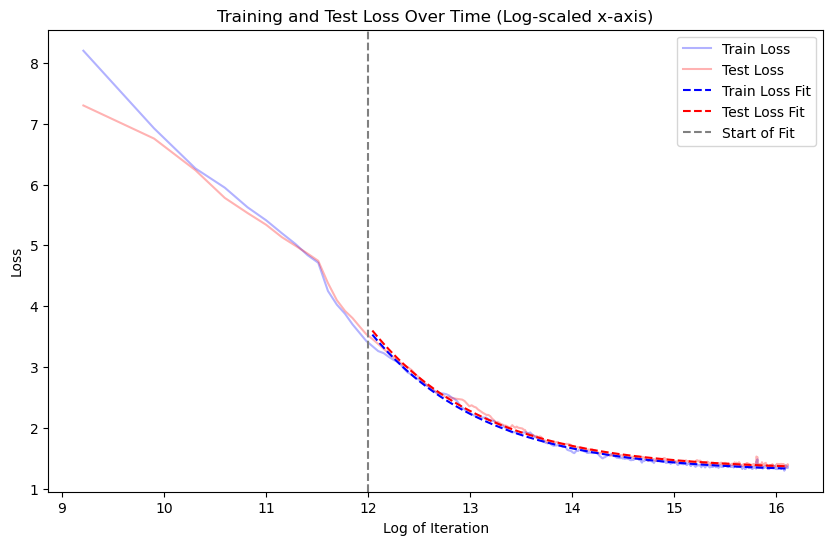

Predicted Loss on Magnitudes of Compute:
Initially trained on 10,000,000.0 iterations
------------------------------------------------------------
1.000e+06 Iters: Loss = 1.735
1.000e+07 Iters (Original Iters): Loss = 1.331
1.000e+08 Iters: Loss = 1.280
1.000e+09 Iters: Loss = 1.273


In [16]:
# Visualize our loss results
train_params, test_params = visualize_loss(filename = model_fn+".csv", 
                                           rolling_window = 10,
                                           start_log_iter = 12)

# Predict loss for different scales
def predict_loss(iteration, params):
    """ Predicts loss using the exponential decay model at a given iteration. """
    log_iter = np.log(iteration)
    return exponential_decay(log_iter, *params)

orig_iters = pd.read_csv(os.path.join('loss_results', model_fn + ".csv")).iloc[:, 0].max()
orig_iters_log = np.log(orig_iters)
iterations = [orig_iters / 10, orig_iters, 10 * orig_iters, 100 * orig_iters]
formatted_iterations = [f"{x:.3e}" for x in iterations]
print(f"Predicted Loss on Magnitudes of Compute:")
print(f"Initially trained on {orig_iters:,} iterations\n{'-'*60}")
for iters, formatted_iter in zip(iterations, formatted_iterations):
    pred_loss = predict_loss(iters, train_params)  # Calculate predicted loss
    label = " (Original Iters)" if iters == orig_iters else ""
    print(f"{formatted_iter:>8} Iters{label}: Loss = {pred_loss:.3f}")

In [13]:
# Import and load our model weights
mymodel = CBOW_NegativeSampling(embed_dim=512, tokenizer=tokenizer)
mymodel.load_weights(os.path.join("trained_models", model_fn+".pth"))

Model weights loaded from trained_models\CBOW-5-NS-16k-2024-04-20_23-29.pth


In [15]:
# Optional can save just the embeddings to the embeddings folder
# mymodel.export_embeddings(os.path.join("embeddings", "v16384_d512_4_26_24.pth"))

Embeddings exported to embeddings\v16384_d512_4_26_24.pth


In [55]:
def print_closest_ids(string):
    tok = tokenizer.encode_as_ids(string)
    tok_text = tokenizer.encode_as_pieces(string)
    if len(tok)>1:
        print("Try new token - token length > 1")
        return

    token_embedding = mymodel.get_embedding(tok)
    closest_ids = mymodel.find_closest_embeddings(token_embedding, n=11)
    closest_ids = (closest_ids.to('cpu')).flatten().tolist()
    print(f"Closest tokens for: {string}\nToken: {tok} - {tok_text}\n{'-'*60}")
    for i, id in enumerate(closest_ids):
        if i == 0:
            continue
        print(f"Id: {i} - {tokenizer.decode(id)}")

# Testing
test_word = "separate"
print_closest_ids(test_word)

Closest tokens for: separate
Token: [3704] - ['▁separate']
------------------------------------------------------------
Id: 1 - distinct
Id: 2 - different
Id: 3 - each
Id: 4 - separately
Id: 5 - forming
Id: 6 - separated
Id: 7 - groups
Id: 8 - divided
Id: 9 - single
Id: 10 - two


In [193]:
# Defining a - b + c = ?
def closest_arith(a, b, c, n=10):
    
    tok_a = tokenizer.encode_as_ids(a)
    tok_b = tokenizer.encode_as_ids(b)
    tok_c = tokenizer.encode_as_ids(c)
    
    if (len(tok_a) + len(tok_b) + len(tok_c)) > 3:
        print("Words not single tokens")
        return
    
    emb_a = mymodel.get_embedding(tok_a)
    emb_b = mymodel.get_embedding(tok_b)
    emb_c = mymodel.get_embedding(tok_c)

    new_emb = (emb_a - emb_b + emb_c)
    new_emb = new_emb / new_emb.norm()
    closest_ids = mymodel.find_closest_embeddings(new_emb, n)
    closest_ids = (closest_ids.to('cpu')).flatten().tolist()
    print(f"Closest tokens for: '{a}' - '{b}' + '{c}'\n{'-'*60}")
    for i, id in enumerate(closest_ids):
        print(f"Id: {i+1} - {tokenizer.decode(id)}")

a = "Paris"
b = "France"
c = "Germany"
closest_arith(a, b, c)

Closest tokens for: 'Paris' - 'France' + 'Germany'
------------------------------------------------------------
Id: 1 - Paris
Id: 2 - Germany
Id: 3 - London
Id: 4 - Berlin
Id: 5 - Leipzig
Id: 6 - recently
Id: 7 - 189
Id: 8 - Europe
Id: 9 - Italy
Id: 10 - Boston
